In [21]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling1D, LSTM, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler

precision = Precision()
SSscaler = StandardScaler()
MMscaler = MinMaxScaler()

In [24]:
# Trying to develop further feature engineering
def pre_processing(df):

    #getting the columns of interest and dropping nulls
    df = df[['description','price','points','country']].dropna()
    df = df.reset_index(drop=True)

    # number of words
    df['num_words'] = df.description.apply(len)

    # creating the dummie variables from  the country column
    dummies = pd.get_dummies(df.country, drop_first =True)
    df = pd.concat([df, dummies], axis=1)

    # Creating a new y target that is a diochotomous variable
    df['y'] = pd.cut(df.points, bins=[0,91.1,100], labels=False).astype(int)

    # dropping the points variable now that we have the y variable. 
    df.drop(['points', 'country'], axis = 1, inplace=True)

    # string representation of the ingredient list
    df['description'] = df.description.astype('str')

    #changing the data type
    df['price'] = df['price'].astype(float)
    df['num_words'] = df['num_words'].astype(float)

    #scaling price and number of words
    df[['scaled_price','scaled_num_words']] = pd.DataFrame(SSscaler.fit_transform(df[['price','num_words']]))

    
    # dropping the unscaled price and number of words
    df = df.drop('price', 1)
    df = df.drop('num_words', 1)

    # #shuffle dataframe
    df = df.sample(frac=1)

    return df

In [25]:
df = pre_processing(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLPSandBox/winereviews.csv', encoding='ISO-8859-1'))

In [26]:
y = df['y']
X = df.drop('y', axis=1)

In [27]:
# split up the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12)

In [28]:
X_train.head();
description_train = X_train['description']
description_test = X_test['description']

#subsetting the numeric variables
numeric_train = X_train[['scaled_price','scaled_num_words']].to_numpy()
numeric_test = X_test[['scaled_price','scaled_num_words']].to_numpy()

In [29]:
MAX_VOCAB_SIZE = 60000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(description_train)
sequences_train = tokenizer.texts_to_sequences(description_train)
sequences_test = tokenizer.texts_to_sequences(description_test)

In [30]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 34308 unique tokens.


In [31]:
nlp_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', nlp_train.shape)

# get sequence length
T = nlp_train.shape[1]

# next I need now the true data train with the additional features


Shape of data train tensor: (120762, 136)


In [32]:
nlp_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', nlp_test.shape)

Shape of data test tensor: (16468, 136)


In [33]:


# We get to choose embedding dimensionality
D = 70

# Hidden state dimensionality
M = 40


nlp_input = Input(shape=(T,),name= 'nlp_input')
meta_input = Input(shape=(2,), name='meta_input')
emb = Embedding(V + 1, D)(nlp_input)
emb = Bidirectional(LSTM(32, return_sequences=True))(emb)
emb = Dropout(0.75)(emb)
emb = Bidirectional(LSTM(64, return_sequences=True))(emb)
emb = Dropout(0.75)(emb)
emb = Bidirectional(LSTM(128))(emb)
nlp_out = Dropout(0.80)(emb)
x = tf.concat([nlp_out, meta_input], 1)
x = Dense(32, activation='swish')(x)
x = Dropout(0.70)(x)
x = Dense(64, activation='swish')(x)
x = Dropout(0.75)(x)
x = Dense(128, activation='swish')(x)
x = Dropout(0.90)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[nlp_input, meta_input], outputs=[x])


In [34]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('val_accuracy')>=0.9400) and (logs.get('val_precision')>=0.8300)):
      print("\n╰( ͡° ͜ʖ ͡° )つ──☆ Reached 94% accuracy, 83% precision,so cancelling training!")
      self.model.stop_training = True

In [35]:
mycallback = myCallback()


In [36]:
# Compile and fit
model.compile(
  loss='binary_crossentropy',
  #optimizer=optimizer1,
  optimizer='adam',
  metrics=['accuracy', precision]
)


print('Training model...')
r = model.fit(
  [nlp_train, numeric_train],
  y_train,
  epochs=10, #changing this to one to just prove it works with the new features
  validation_data=([nlp_test, numeric_test], y_test),
  callbacks=[mycallback])


Training model...
Epoch 1/10
3774/3774 [==============================] - 161s 40ms/step - loss: 0.2475 - accuracy: 0.8995 - precision: 0.6943 - val_loss: 0.1747 - val_accuracy: 0.9234 - val_precision: 0.6908
Epoch 2/10
3774/3774 [==============================] - 151s 40ms/step - loss: 0.1844 - accuracy: 0.9254 - precision: 0.7748 - val_loss: 0.1583 - val_accuracy: 0.9342 - val_precision: 0.8152
Epoch 3/10
3774/3774 [==============================] - 151s 40ms/step - loss: 0.1486 - accuracy: 0.9447 - precision: 0.8318 - val_loss: 0.1572 - val_accuracy: 0.9391 - val_precision: 0.7676
Epoch 4/10
3774/3774 [==============================] - 151s 40ms/step - loss: 0.1219 - accuracy: 0.9559 - precision: 0.8652 - val_loss: 0.1695 - val_accuracy: 0.9393 - val_precision: 0.7491
Epoch 5/10
3774/3774 [==============================] - 151s 40ms/step - loss: 0.0988 - accuracy: 0.9650 - precision: 0.8936 - val_loss: 0.1662 - val_accuracy: 0.9459 - val_precision: 0.7882
Epoch 6/10
3774/3774 [=====

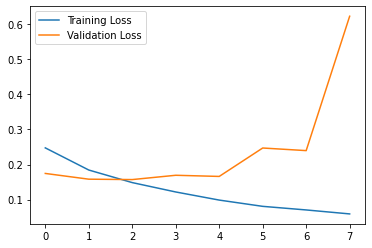

In [37]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='Training Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()

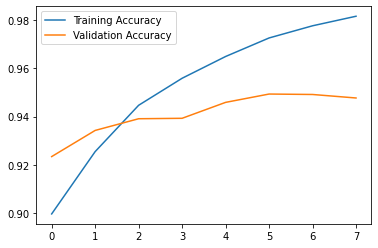

In [38]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='Training Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

In [39]:
tf.keras.backend.clear_session()